<h3><b>Importing required dependencies</b></h3>

In [1]:
import json 
import os

import numpy as np 
import matplotlib.pyplot as plt

import seaborn as sns
import pickle #for saving history object

from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam


from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from datetime import datetime

<h3><b>Data Preprocessing</b></h3>

In [8]:
# Define directories and hyperparameters
train_dir ='D:/Temp-main project/Dataset_test/New Plant disease dataset/train'
val_dir = 'D:/Temp-main project/Dataset_test/New Plant disease dataset/valid'
test_dir='D:/Temp-main project/Dataset_test/New Plant disease dataset/test/test'

(256, 256, 3)


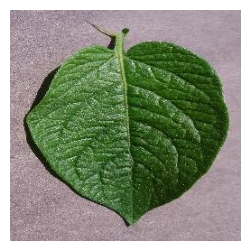

In [9]:
image_path = r'D:\Temp-main project\Dataset_test\New Plant disease dataset\train\Potato___healthy\750584fd-72e0-45c8-b37c-97208bd559cc___RS_HL 1885_flipTB.JPG'

# Read the image
img = plt.imread(image_path)

print(img.shape)
plt.figure(figsize=(3,3))
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers
plt.show()

In [10]:
image_path = r'D:\Temp-main project\Dataset_test\New Plant disease dataset\train\Potato___healthy\750584fd-72e0-45c8-b37c-97208bd559cc___RS_HL 1885_flipTB.JPG'

# Read the image
img = plt.imread(image_path)

print(img)

[[[170 152 164]
  [169 151 163]
  [143 125 137]
  ...
  [171 155 166]
  [166 150 161]
  [161 145 156]]

 [[173 155 167]
  [115  97 109]
  [145 127 139]
  ...
  [174 158 169]
  [169 153 164]
  [165 149 160]]

 [[184 166 178]
  [175 157 169]
  [176 158 170]
  ...
  [174 158 169]
  [171 155 166]
  [168 152 163]]

 ...

 [[187 168 174]
  [169 150 156]
  [168 149 155]
  ...
  [173 156 164]
  [165 148 156]
  [158 141 149]]

 [[163 144 150]
  [159 140 146]
  [154 135 141]
  ...
  [172 155 163]
  [167 150 158]
  [163 146 154]]

 [[180 161 167]
  [170 151 157]
  [168 149 155]
  ...
  [171 154 162]
  [171 154 162]
  [170 153 161]]]


In [11]:
#Image and train parameters
img_size = (224, 224)
batch_size = 16
epochs = 20
patience = 5

<h3><b>Splitting of Data for Train, Validation & Test</b></h3>

In [12]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 12750 images belonging to 17 classes.
Found 7809 images belonging to 17 classes.
Found 338 images belonging to 17 classes.


<h3><b>Building Efficientnet Model</b></h3>

In [13]:
# Load EfficientNetB0 model without the top layer
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [14]:
fine_tune_at = 50  

# Freeze all layers up to the specified fine-tune starting point

for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable = False



In [15]:
# Create a new model with custom top layers
model = Sequential() 
model.add(efficientnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))  # You can adjust the number of neurons as needed
model.add(Dense(17, activation='softmax'))  # num_classes is the number of disease classes
# Add a dropout layer with a dropout rate of 0.2 to prevent overfitting
model.add(layers.Dropout(0.2))


In [16]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Display a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 17)                2193      
                                                                 
 dropout (Dropout)           (None, 17)                0         
                                                                 
Total params: 4215732 (16.08 MB)
Trainable params: 41508

<h3><b>Model Training</b></h3>

In [18]:
# Get the base model name
base_model_name = efficientnet_model.name

# Get the current date and time
current_date = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

# Define the file name using the model name and current date
file_name = f"models/{base_model_name}_plant_disease_detection[{current_date}].h5"

# Check if the file already exists
if os.path.exists(file_name):
    # Prompt the user to enter a new name
    print(file_name," already exits!!")
    new_name = input("A file with the same name already exists. Please enter a new name: ")
    file_name = f"models/{new_name}.h5"
print("New file name : ",file_name)

# Define callbacks
checkpoint = ModelCheckpoint('plant_disease_detection_efficientNet.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, restore_best_weights=True)

New file name :  models/efficientnetb0_plant_disease_detection[12-04-2024_22-49-01].h5


In [19]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20


796/796 [==============================] - ETA: 0s - loss: 3.7190 - accuracy: 0.6397
Epoch 1: val_accuracy improved from -inf to 0.45159, saving model to plant_disease_detection_efficientNet.h5


c:\Users\nehae\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


796/796 [==============================] - 1045s 1s/step - loss: 3.7190 - accuracy: 0.6397 - val_loss: 2.2924 - val_accuracy: 0.4516
Epoch 2/20
796/796 [==============================] - ETA: 0s - loss: 3.4363 - accuracy: 0.7191
Epoch 2: val_accuracy improved from 0.45159 to 0.55008, saving model to plant_disease_detection_efficientNet.h5
796/796 [==============================] - 1091s 1s/step - loss: 3.4363 - accuracy: 0.7191 - val_loss: 1.6398 - val_accuracy: 0.5501
Epoch 3/20
796/796 [==============================] - ETA: 0s - loss: 3.4698 - accuracy: 0.7278
Epoch 3: val_accuracy improved from 0.55008 to 0.88704, saving model to plant_disease_detection_efficientNet.h5
796/796 [==============================] - 948s 1s/step - loss: 3.4698 - accuracy: 0.7278 - val_loss: 0.3340 - val_accuracy: 0.8870
Epoch 4/20
796/796 [==============================] - ETA: 0s - loss: 3.4565 - accuracy: 0.7386
Epoch 4: val_accuracy did not improve from 0.88704
796/796 [==============================

In [20]:
# Load EfficientNetB0 model without the top layer
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


In [21]:
# Save history object
with open('history[inception2024].pkl', 'wb') as f:
    pickle.dump(history.history, f)


In [22]:

# Load history object
with open('history[inception2024].pkl', 'rb') as f:
    loaded_history = pickle.load(f)


<h3><b>Evaluation of Model</b></h3>

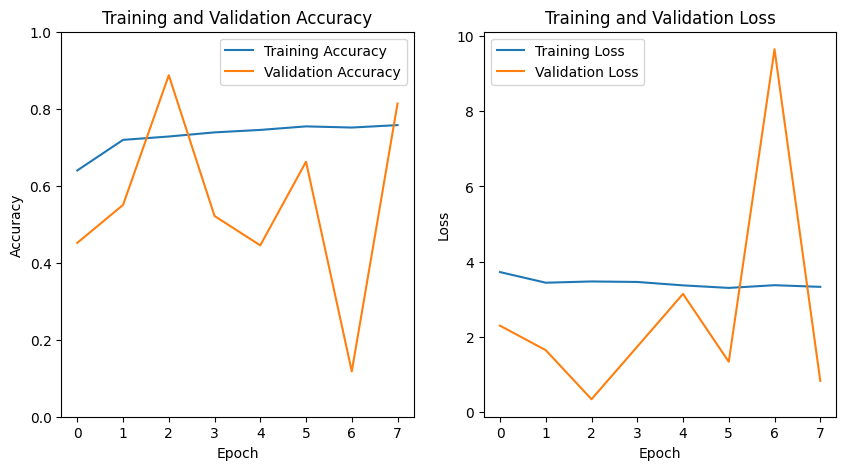

In [23]:
# Plot training history
plt.figure(figsize=(10, 5))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(loaded_history['accuracy'], label='Training Accuracy')
plt.plot(loaded_history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.title('Training and Validation Accuracy')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(loaded_history['loss'], label='Training Loss')
plt.plot(loaded_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

22/22 [==============================] - 20s 581ms/step
There were 259 errors in 338 tests for an accuracy of 23.37


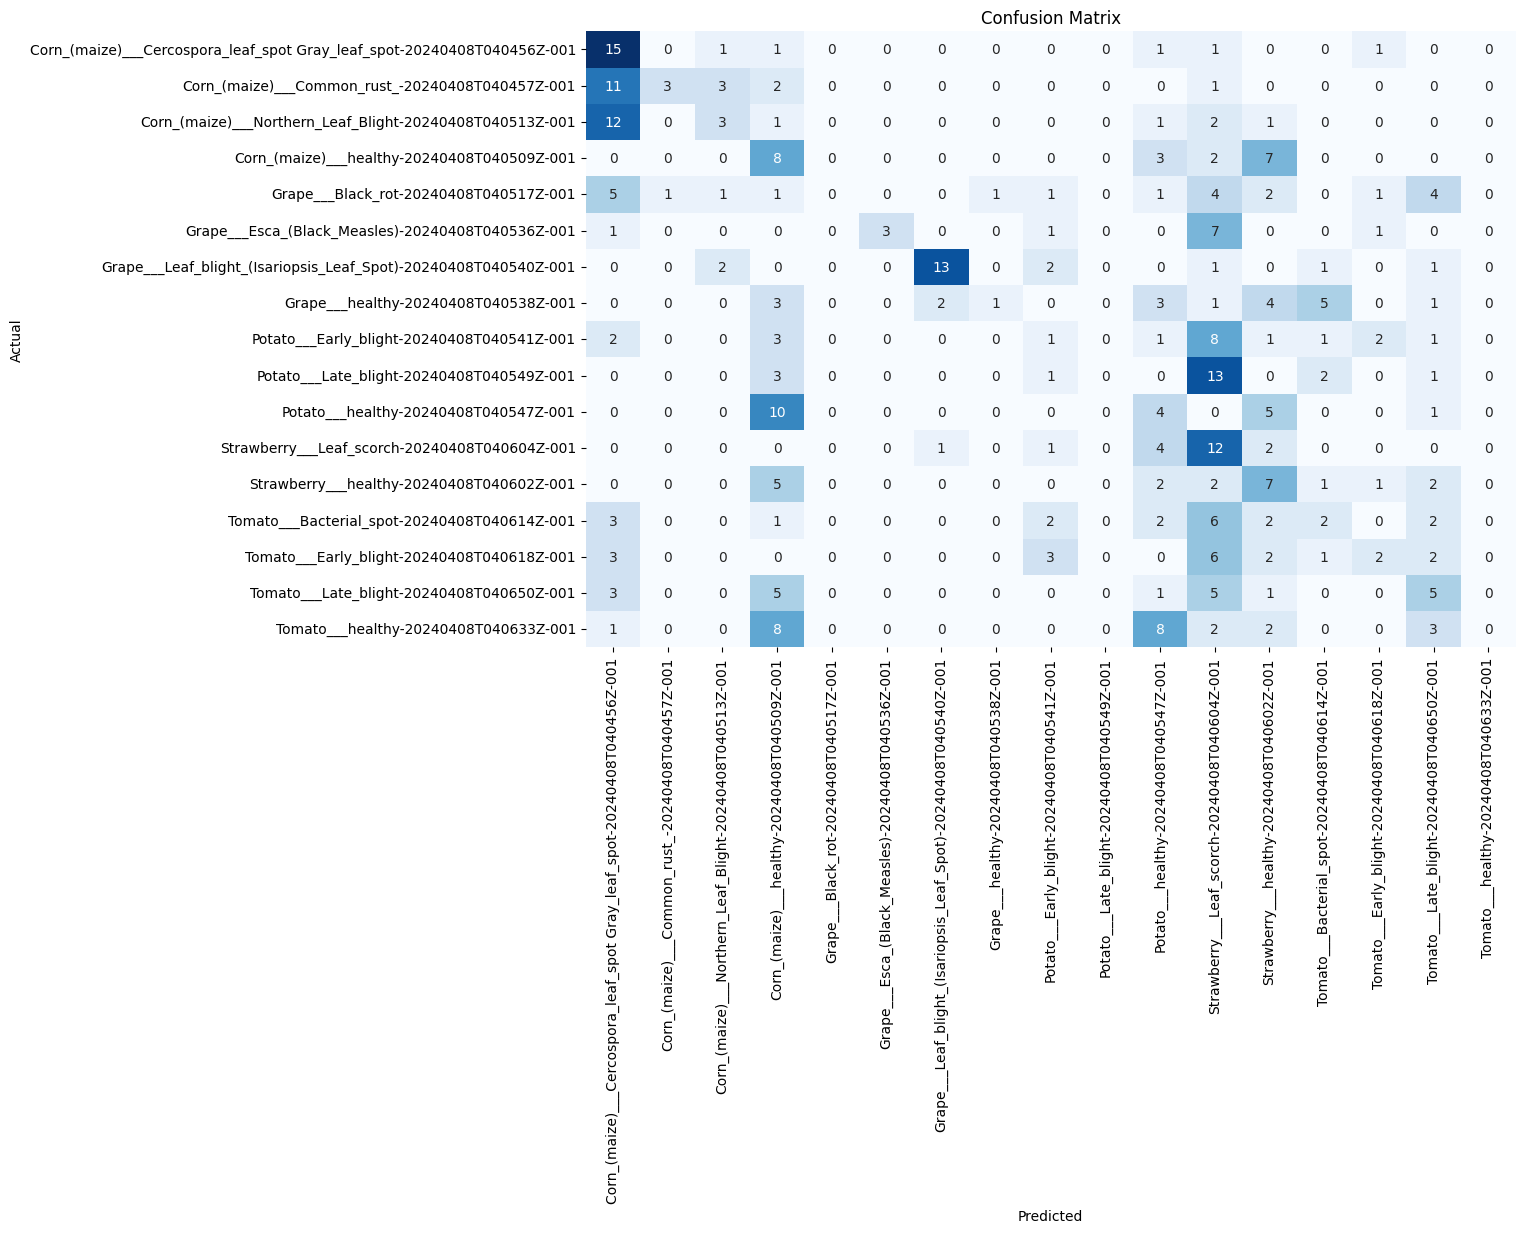

Classification Report:
----------------------
                                                                          precision    recall  f1-score   support

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot-20240408T040456Z-001     0.2679    0.7500    0.3947        20
                       Corn_(maize)___Common_rust_-20240408T040457Z-001     0.7500    0.1500    0.2500        20
               Corn_(maize)___Northern_Leaf_Blight-20240408T040513Z-001     0.3000    0.1500    0.2000        20
                            Corn_(maize)___healthy-20240408T040509Z-001     0.1569    0.4000    0.2254        20
                                 Grape___Black_rot-20240408T040517Z-001     0.0000    0.0000    0.0000        22
                      Grape___Esca_(Black_Measles)-20240408T040536Z-001     1.0000    0.2308    0.3750        13
        Grape___Leaf_blight_(Isariopsis_Leaf_Spot)-20240408T040540Z-001     0.8125    0.6500    0.7222        20
                                   Grape___healt

c:\Users\nehae\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nehae\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nehae\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [24]:
def predictor(test_gen):    
    y_pred = []
    error_list = []
    error_pred_list = []
    y_true = test_gen.labels
    classes = list(test_gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = model.predict(test_gen, verbose=1)
    tests = len(preds)    
    for i, p in enumerate(preds):        
        pred_index = np.argmax(p)         
        true_index = test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors = errors + 1
            file = test_gen.filenames[i]
            error_list.append(file)
            error_class = classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
            
    acc = (1 - errors/tests) * 100
    msg = f'There were {errors} errors in {tests} tests for an accuracy of {acc:.2f}'
    print(msg)
    
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    f1score = f1_score(ytrue, ypred, average='weighted') * 100
    if class_count <= 30:
        cm = confusion_matrix(ytrue, ypred)
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count) + .5, classes, rotation=90)
        plt.yticks(np.arange(class_count) + .5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    
    clr = classification_report(y_true, y_pred, target_names=classes, digits=4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    
    return errors, tests, error_list, error_pred_list, f1score, y_pred, y_true

errors, tests, error_list, error_pred_list, f1score, y_pred, y_true = predictor(test_generator)

In [25]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('/nTest accuracy:', test_acc)
print('Test Loss:', test_loss)


22/22 - 9s - loss: 5.9095 - accuracy: 0.2337 - 9s/epoch - 417ms/step
/nTest accuracy: 0.2337278127670288
Test Loss: 5.909483909606934


In [26]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in train_generator.class_indices.items()}

class_indices

# Save class indices to a JSON file
with open('class_indices_densenet.json', 'w') as f:
    json.dump(class_indices, f)

<h3><b>Prediction of Disease</b></h3>

In [27]:
# Function to predict class of an image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def predict_disease(image_path):
    img = load_img(image_path, target_size=img_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_indices[predicted_class_index]
    confidence = prediction[0][predicted_class_index]

    return predicted_class, confidence


In [28]:
# Load class indices
with open('class_indices_densenet.json', 'w') as f:
    json.dump(class_indices, f)
# Load remedies
#with open('remedies.json', 'r') as f:
    #remedies= json.load(f)

In [29]:
image_path = r'D:\Temp-main project\Dataset_test\New Plant disease dataset\test\test\Corn_(maize)___Common_rust_-20240408T040457Z-001\Corn_(maize)___Common_rust_\download (2).jpeg' 

disease, confidence = predict_disease(image_path)

print(f'Predicted Disease: {disease}, Confidence: {confidence}')

'''if disease.strip() in remedies:
    remedy = remedies[disease]
    print(f'Remedies: {remedy}')
else:
    print('No remedies found for this disease.')'''

1/1 [==============================] - 10s 10s/step
Predicted Disease: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot, Confidence: 0.9875031113624573


"if disease.strip() in remedies:\n    remedy = remedies[disease]\n    print(f'Remedies: {remedy}')\nelse:\n    print('No remedies found for this disease.')"